In [3]:
import numpy as np
import random
import time
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import Model, callbacks
from tensorflow.keras.layers import Dense, Flatten, Reshape, UpSampling2D,BatchNormalization, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 2s 0us/step


In [5]:
# Enter BUFFER_SIZE so that the sample size is a multiple of BATCH_SIZE
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(f'Input data shape: {x_train.shape}')
print(f'Number of labels: {y_train.size}')

Input data shape: (60000, 28, 28)
Number of labels: 60000


In [6]:
# Data normalization
x_train = x_train / 255
x_test = x_test / 255

# We form tensors for training and test samples
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Splitting the training sample into BATCHES
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-11-05 16:23:18.007454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 16:23:18.378959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 16:23:18.379091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

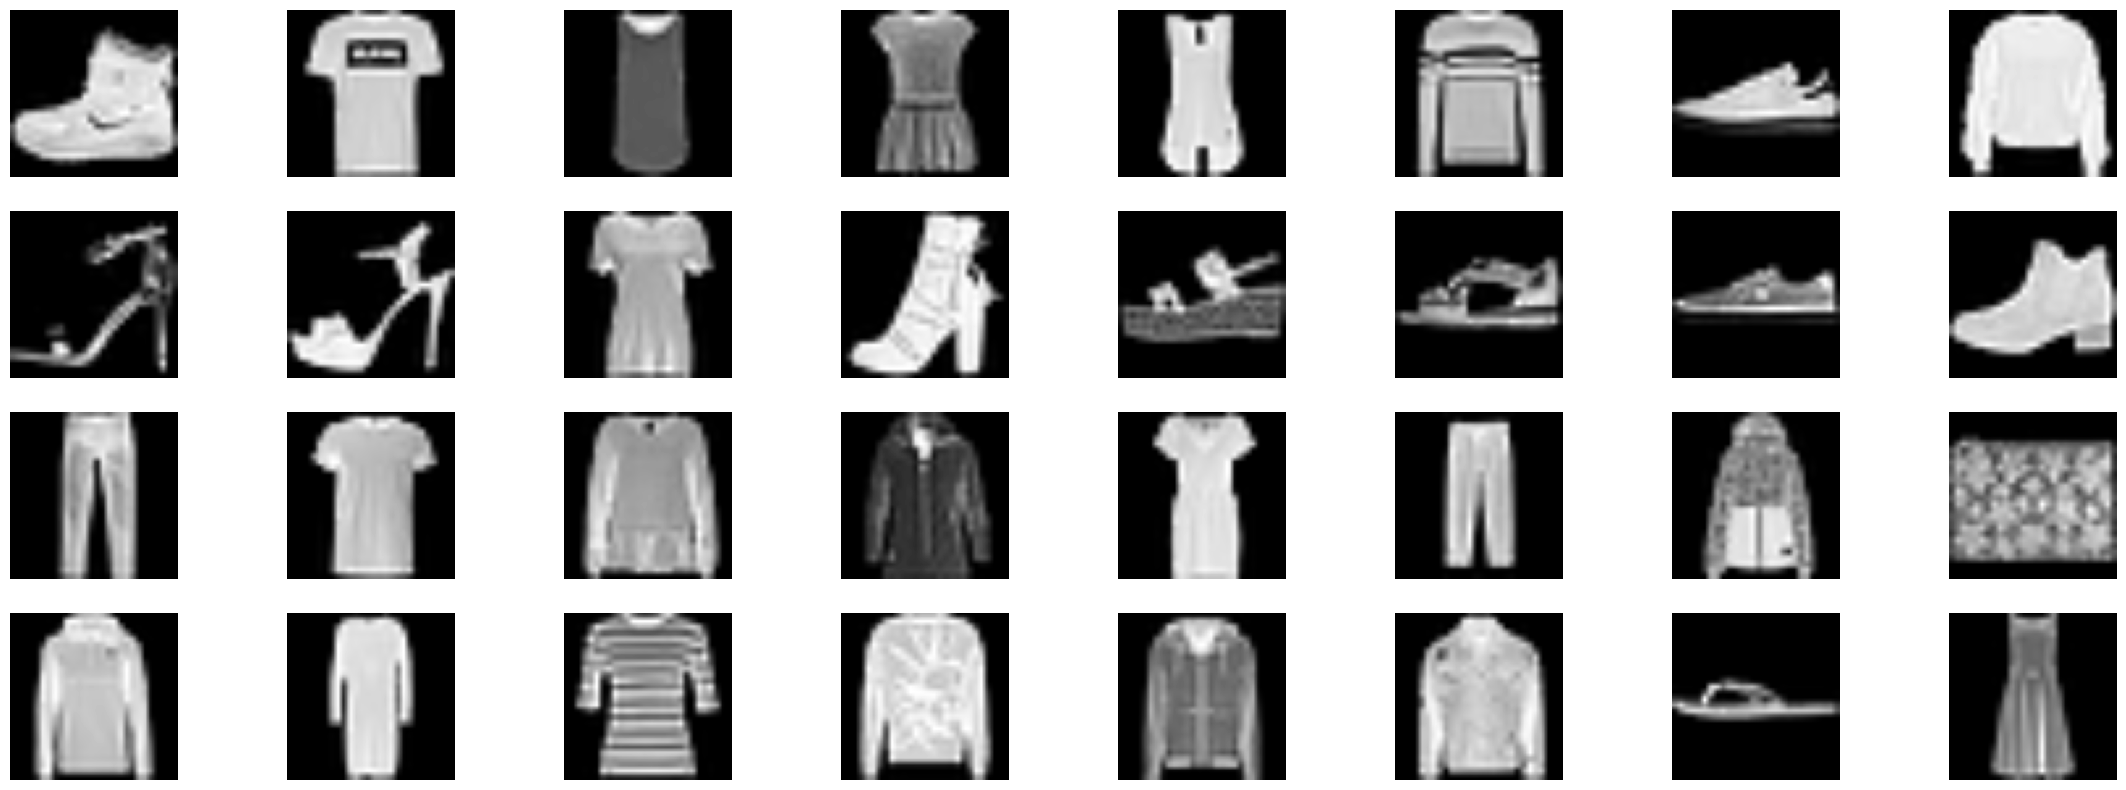

In [7]:
cnt_imgs = 32
counter = 0
IMAGE_SIZE = (64, 64)
plt.figure(figsize=(28, 10))
for img in x_train:
    plt.subplot(4, 8, counter + 1)
    draw_img = cv2.resize(img, IMAGE_SIZE)
    plt.imshow(draw_img, cmap='gray')
    plt.axis('off')
    counter += 1
    if counter == cnt_imgs:
        break

In [8]:
# loss function
cross_entropy = BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Function of finding the value of the loss function for the generator (for BATCH)"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    """Function of finding the value of the loss function for the discriminator (for BATCH)"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
generator_optimizer = tf.optimizers.Adam(1e-4)
discriminator_optimizer = tf.optimizers.Adam(1e-4)

In [10]:
# We will feed a vector of independent random variables of the hidden dim dimension to the input of the generator
hidden_dim = 2

In [12]:
# First, let's create a generator model
generator = Sequential(name='generator')
generator.add(Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim, )))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 256)))  # got a tensor
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))

In [13]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 batch_normalization_3 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819328    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                         

In [14]:
# next let's create a discriminator model
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='elu', input_shape=(28, 28, 1)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='elu'))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

In [15]:
# compiling neural networks
generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [16]:
# Generator and Discriminator training
@tf.function
def train_step(images) -> (float, float):
    """Function for updating weight coefficients at one training step (for one BATCH)"""
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        return gen_loss, disc_loss

In [17]:
# the learning process for all epochs
def train(dataset,  epochs) -> None:
    """A function to start the learning process for all epochs for the generator and discriminator
    dataset: a set of real images that we store in  generator"""
    history = []
    max_print_label = 10
    th = BUFFER_SIZE // (BATCH_SIZE * max_print_label)

    for epoch in range(1, EPOCHS + 1):
        print(f'{epoch}/{EPOCHS}: ', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0):
                print('=', end='')
            n += 1
        print('>', end = ' ')

        history += [gen_loss_epoch / n]
        print(': loss = ' + str(history[-1]))
        print(f'The time of the epoch {epoch} is: {time.time() - start} second')
    return history

In [18]:
def train(dataset, epochs) -> None:
    """A function to start the learning process for all epochs for the generator and discriminator
    dataset: a set of real images that we store in generator"""
    history = []

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}:', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            n += 1

        history.append(gen_loss_epoch / n)
        print(f' Loss: {history[-1]}')
        print(f'The time of the epoch {epoch} is: {time.time() - start} seconds')

    return history


In [19]:
# # Starting the learning process
EPOCHS = 100
gen_history = train(train_dataset, EPOCHS)

Epoch 1/100:

2023-11-05 16:24:45.562373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-05 16:24:45.891261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-05 16:24:47.680131: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6079b9d3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-05 16:24:47.680157: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-05 16:24:47.684148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-05 16:24:47.777505: I ./tensorflow/compiler/jit/device_compil

 Loss: 1.1905733346939087
The time of the epoch 1 is: 14.983270168304443 seconds
Epoch 2/100: Loss: 1.1667624711990356
The time of the epoch 2 is: 9.672273874282837 seconds
Epoch 3/100: Loss: 1.2332336902618408
The time of the epoch 3 is: 9.72109866142273 seconds
Epoch 4/100: Loss: 1.5147678852081299
The time of the epoch 4 is: 9.761705875396729 seconds
Epoch 5/100: Loss: 1.5511035919189453
The time of the epoch 5 is: 9.785257339477539 seconds
Epoch 6/100: Loss: 1.3644598722457886
The time of the epoch 6 is: 9.803411483764648 seconds
Epoch 7/100: Loss: 1.4716418981552124
The time of the epoch 7 is: 9.825650691986084 seconds
Epoch 8/100: Loss: 1.690816879272461
The time of the epoch 8 is: 9.844680547714233 seconds
Epoch 9/100: Loss: 1.6028090715408325
The time of the epoch 9 is: 9.844665288925171 seconds
Epoch 10/100: Loss: 1.4198585748672485
The time of the epoch 10 is: 9.85844874382019 seconds
Epoch 11/100: Loss: 1.458622694015503
The time of the epoch 11 is: 9.87631893157959 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


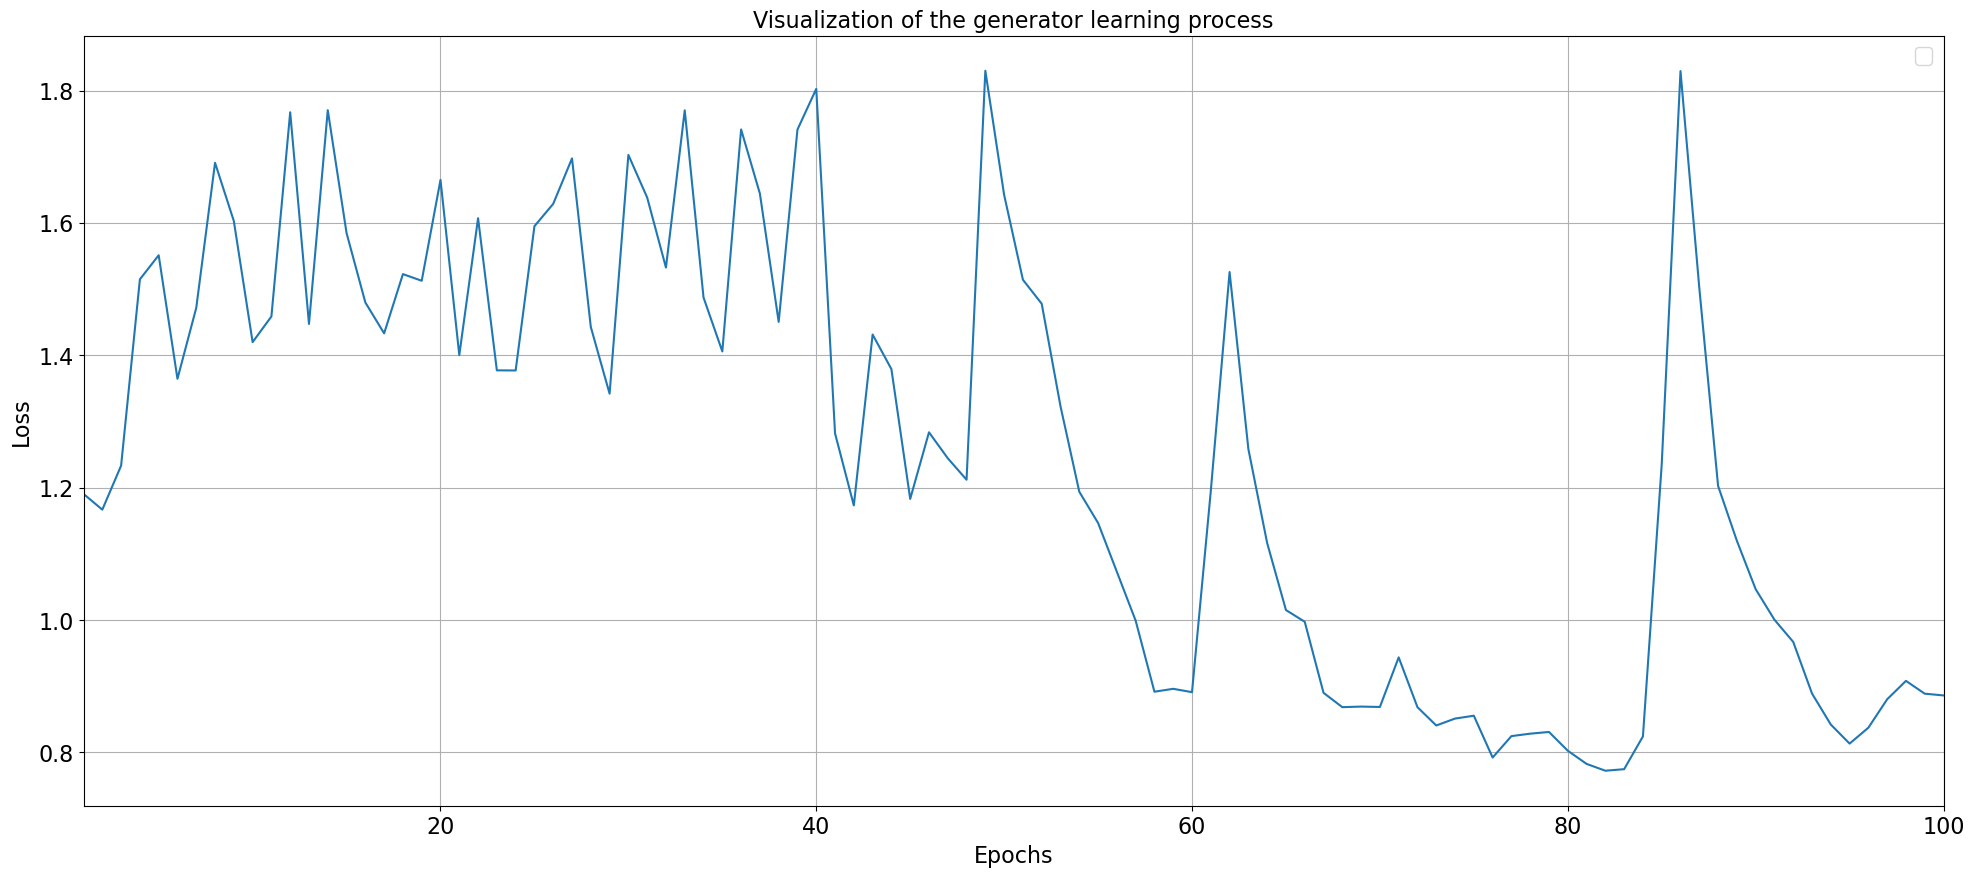

In [20]:
plt.figure(figsize=(24, 10))
plt.title('Visualization of the generator learning process', fontsize=16)
plt.plot(np.arange(1, EPOCHS + 1), gen_history)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1, EPOCHS)
plt.grid()
plt.legend(fontsize=16)
plt.show()

1/1 [==============================] - 0s 18ms/step


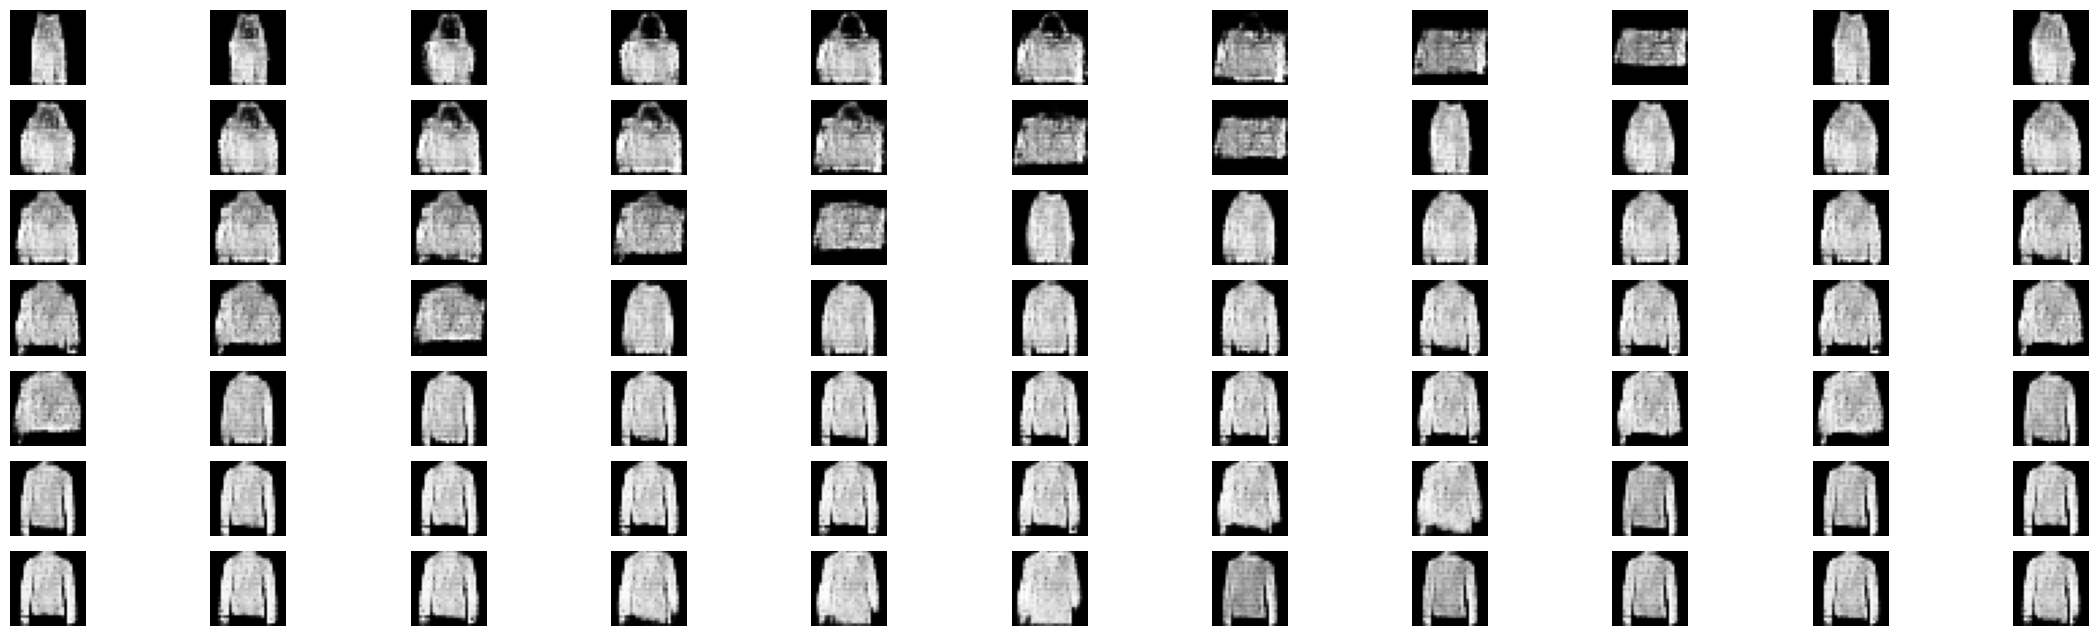

In [21]:
n = 4
total = 2 * n + 1
cnter = 0
plt.figure(figsize=(28, 8))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(7, 11, num)
        num += 1
        img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
        plt.imshow(img[0, :, :, 0], cmap='gray')
        plt.axis('off')
        if num == 78:
            break
plt.show()

In [22]:
import tensorflow as tf

# Assuming you have a trained discriminator model and a validation dataset
#discriminator_model = your_trained_discriminator_model
#validation_dataset = your_validation_dataset

# Define a function to evaluate the discriminator's performance
def evaluate_discriminator_performance(discriminator, dataset):
    correct_predictions = 0
    total_samples = 0

    for image_batch, labels in dataset:
        # Apply the discriminator to the batch of images
        predictions = discriminator(image_batch, training=False)

        # Calculate the number of correct predictions
        correct_predictions += tf.reduce_sum(tf.cast(tf.math.round(predictions) == labels, tf.float32))

        # Update the total number of samples
        total_samples += len(labels)

    accuracy = correct_predictions / total_samples
    return accuracy

# Use the function to evaluate the discriminator's performance on the validation dataset
discriminator_accuracy = evaluate_discriminator_performance(discriminator, x_test)

print(f"Discriminator Accuracy on Validation Dataset: {discriminator_accuracy * 100:.2f}%")

ValueError: too many values to unpack (expected 2)

In [ ]:
meta = [100,150,200]
s_meta = [20,50,100]

for i in meta:
    for j in s_meta: